In [1]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as sp
%load_ext google.cloud.bigquery
import pickle
from matplotlib import pyplot as plt
with open('design.pkl','rb') as f:
    set_params = pickle.load(f)
plt.rcParams.update(set_params)

In [2]:
def ft_cleaner(x):
    x = x.replace('GAS BI-FUEL', 'Other').replace('GAS', 'Other').replace('GAS DIESEL', 'Other').replace('PETROL/GAS', 'Other').replace('LPG', 'Other').replace('STEAM', 'Other').replace('LNG', 'Other').replace('OTHER', 'Other').replace('CNG', 'Other')
    x = x.replace('FUEL CELLS', 'Other')
    x = x.replace('PETROL', 'Petrol').replace('Petrol/Other', 'Petrol')
    x = x.replace('HYBRID ELECTRIC (CLEAN)', 'Hybrid').replace('HYBRID ELECTRIC', 'Hybrid').replace('ELECTRIC DIESEL', 'Hybrid')
    x = x.replace('DIESEL', 'Diesel').replace('Other Diesel', 'Diesel')
    x = x.replace('ELECTRICITY', 'Pure Electric').replace('ELECTRIC', 'Pure Electric')
    return x

In [3]:
%%bigquery car_targets --project rugged-baton-283921
SELECT make, AVG(co2Emissions) as co2Target
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'
AND monthOfFirstRegistration > '2020-12-31'
AND monthOfFirstRegistration < '2022-01-01'
AND co2Emissions > 0
GROUP BY make

Downloading: 100%|██████████| 88/88 [00:01<00:00, 65.63rows/s]


In [4]:
# car_targets.sort_values('meanCo2').plot(kind='bar', x='make', figsize=(40, 10))

In [5]:
%%bigquery df_activity --project rugged-baton-283921
SELECT 
    make, 
    COUNT(*) as totalSales,
    COUNTIF(co2Emissions > 0) as nonzevSales,
    COUNTIF(co2Emissions = 0) as zevSales,
    SUM(co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'
AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE typeApproval = 'M1'
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)
GROUP BY make
ORDER BY totalSales ASC;

Downloading: 100%|██████████| 32/32 [00:00<00:00, 44.59rows/s]


In [6]:
dfa = df_activity.merge(car_targets, how='left', on='make')
dfa['co2Allowances'] = dfa.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
dfa['co2Compliance'] = dfa.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

In [7]:
mandate =.22

In [8]:
def co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2Compliance / 167
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits
        
def proposed_co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    conversion_factor = row.co2Target
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2Compliance / conversion_factor
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits


In [9]:
dfa['co2_to_mandate_allowances'] = dfa.apply(lambda row: co2_to_zev(row, mandate=mandate), axis=1)
dfa['proposed_co2_to_mandate_allowances'] = dfa.apply(lambda row: proposed_co2_to_zev(row, mandate=mandate), axis=1)


In [10]:
dfa

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2_to_mandate_allowances,proposed_co2_to_mandate_allowances
0,JEEP,2581,2581,0,265383.0,163.136461,4.210552e+05,155672.206001,141.955000,141.955000
1,DS,3464,2857,607,315869.0,123.471191,3.527572e+05,36888.192061,190.520000,190.520000
2,LEXUS,8191,7784,407,942981.0,150.769783,1.173592e+06,230610.989825,450.505000,450.505000
3,POLESTAR,9224,2,9222,26.0,192.000000,3.840000e+02,358.000000,2.143713,1.864583
4,JAGUAR,10120,6147,3973,996353.0,174.368494,1.071843e+06,75490.131766,452.036717,432.934472
5,PORSCHE,13961,10106,3855,2199395.0,219.315459,2.216402e+06,17007.030018,101.838503,77.545970
6,CUPRA,16216,10917,5299,1681421.0,118.189238,1.290272e+06,-391149.088293,0.000000,0.000000
7,SUZUKI,16984,16984,0,1998766.0,117.627482,1.997785e+06,-980.852363,0.000000,0.000000
8,FIAT,21838,16242,5596,2031878.0,130.535102,2.120151e+06,88273.121322,528.581565,676.240492
9,HONDA,21839,21498,341,2626905.0,124.830076,2.683597e+06,56691.979291,339.472930,454.153206


In [11]:
mandate = .22
dfa['ZEVMallowances'] = dfa.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
dfa['ZEV Surplus'] = dfa.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
dfa['ZEV Surplus after CO2'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
dfa['ZEV Surplus after CO2 - Proposed'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [12]:
(1 - (mandate * .25)) * 135525

128071.125

In [13]:
dfa[dfa.make == 'VOLKSWAGEN']

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2_to_mandate_allowances,proposed_co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2,ZEV Surplus after CO2 - Proposed
31,VOLKSWAGEN,135525,113938,21587,15174419.0,139.808545,1.592951e+07,755086.956878,4521.478784,5400.864153,105709.5,-8228.5,-3707.021216,-2827.635847


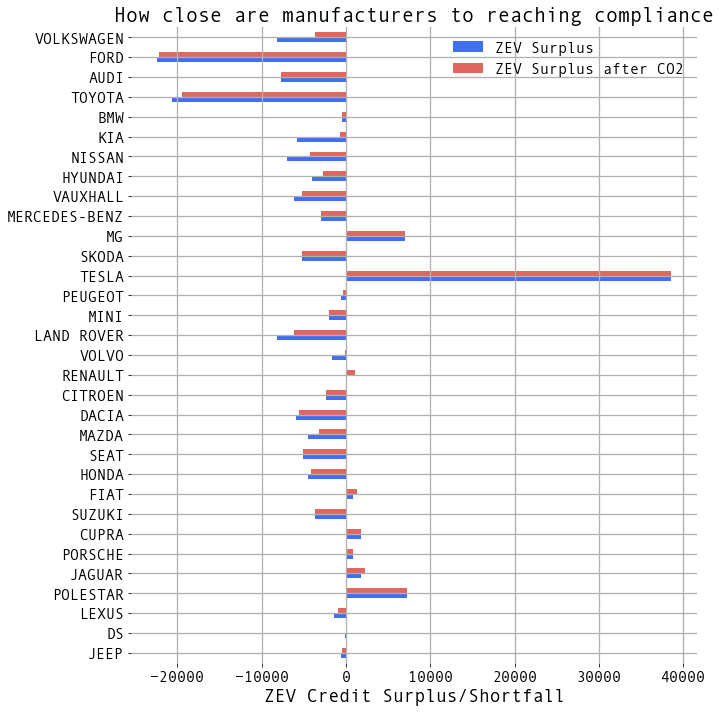

In [14]:
fig, ax = plt.subplots()

dfa.plot(x='make', y=[
    'ZEV Surplus', 
    'ZEV Surplus after CO2', 
    # 'ZEV Surplus after CO2 - Proposed'
], kind='barh', ax=ax, figsize=(10, 10))
ax.set_xlabel('ZEV Credit Surplus/Shortfall')
ax.set_ylabel('')

ax.set_title('How close are manufacturers to reaching compliance')

plt.savefig('plots/top_20_last_12_months.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [15]:
dfa['CO2 Performance'] = dfa.co2Activity / dfa.nonzevSales

In [16]:
dfa_sel = dfa[[
    'make',
    'totalSales',
    'nonzevSales',
    'zevSales',
    'co2Target',
    'CO2 Performance',
    'ZEVMallowances',
    'ZEV Surplus',
    'ZEV Surplus after CO2'
]].rename(columns={
    'make': 'Make',
    'totalSales': 'Total Sales',
    'co2Target': 'CO2 Target',
    'nonzevSales': 'Non-ZEV Sales',
    'zevSales': 'ZEV Sales',
    'ZEVMallowances': 'Allocated allowances',
    'ZEV Surplus': 'Allowance Surplus',
    'ZEV Surplus after CO2': 'Allowance Surplus (after CO2 transfers)'
})

# dfa_sel['Mean CO2'] = 
dfa_sel = round(dfa_sel, ndigits=2)

dfa_sel = dfa_sel.sort_values('Total Sales', ascending=False)

In [17]:
dfa_sel.to_csv('ZEV_compliance_tracker.csv')

# Rolling Performance

In [18]:
%%bigquery df_act --project rugged-baton-283921
SELECT 
    VES.make,
    VES.monthOfFirstRegistration,
    COUNT(*) as totalSales,
    COUNTIF(VES.co2Emissions > 0) as nonzevSales,
    COUNTIF(VES.co2Emissions = 0) as zevSales,
    SUM(VES.co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK VES
WHERE typeApproval = 'M1'
AND CAST(monthOfFirstRegistration AS DATE) > '2020-03-31'
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE typeApproval = 'M1'
#     AND monthOfFirstRegistration > '2020-03-31'
#     AND monthOfFirstRegistration < '2023-04-01'
#     GROUP BY make
#     ORDER BY COUNT(*) DESC
#     LIMIT 20
    
# )

# Volume limit
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE typeApproval = 'M1'
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)



GROUP BY make, monthofFirstRegistration
ORDER BY totalSales ASC;

Downloading: 100%|██████████| 1141/1141 [00:00<00:00, 1245.78rows/s]


In [19]:
# If we want to filter out all but the top five/ten/twenty makes, we can use this
top_makes = df_act.groupby('make').sum().sort_values('totalSales', ascending=False).index.tolist()[:10]

In [20]:
# Make a copy to edit
df = df_act.copy()#.merge(car_targets, how='left', on='make')

In [21]:
df.head()

,make,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity
0,DS,2020-04-01 00:00:00+00:00,1,0,1,0.0
1,TESLA,2022-07-01 00:00:00+00:00,2,0,2,0.0
2,JEEP,2020-04-01 00:00:00+00:00,5,5,0,1145.0
3,SUZUKI,2020-04-01 00:00:00+00:00,5,5,0,613.0
4,TOYOTA,2020-04-01 00:00:00+00:00,7,7,0,712.0


In [22]:
# This turns our numbers into 12 month rolling totals/averages

dfs = []
makes = df.make.unique().tolist()

for make in makes:
    temp_df = df[df.make == make].set_index('monthOfFirstRegistration').sort_index().rolling(12).sum()
    temp_df = temp_df.reset_index().dropna()
    temp_df['make'] = make
    dfs.append(temp_df)
    
df = pd.concat(dfs)

In [23]:
# This gives us the targets for CO2 performance
df = df.reset_index().merge(car_targets, how='left', on='make')

In [24]:
df['co2Allowances'] = df.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
df['co2Compliance'] = df.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)
df['co2_to_mandate_allowances'] = df.apply(lambda row: co2_to_zev(row, mandate=.22), axis=1)
# df['proposed_co2_to_mandate_allowances'] = df.apply(lambda row: proposed_co2_to_zev(row,), axis=1)

In [25]:
mandate = .22
df['ZEVMallowances'] = df.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
df['ZEV Surplus'] = df.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
df['ZEV Surplus after CO2'] = df.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
# df['ZEV Surplus after CO2 - Proposed'] = df.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [26]:
# Are there any manufacturers failing to make Co2 compliance but with surplus ZEV credits, who would need to transfer ZEV credits into the regime 
# We assume that manufacturers would rather transfer from CO2 than purchase CO2 allowances. 
# df[(df['ZEV Surplus'] > 0) & (df.co2Compliance < 0)]

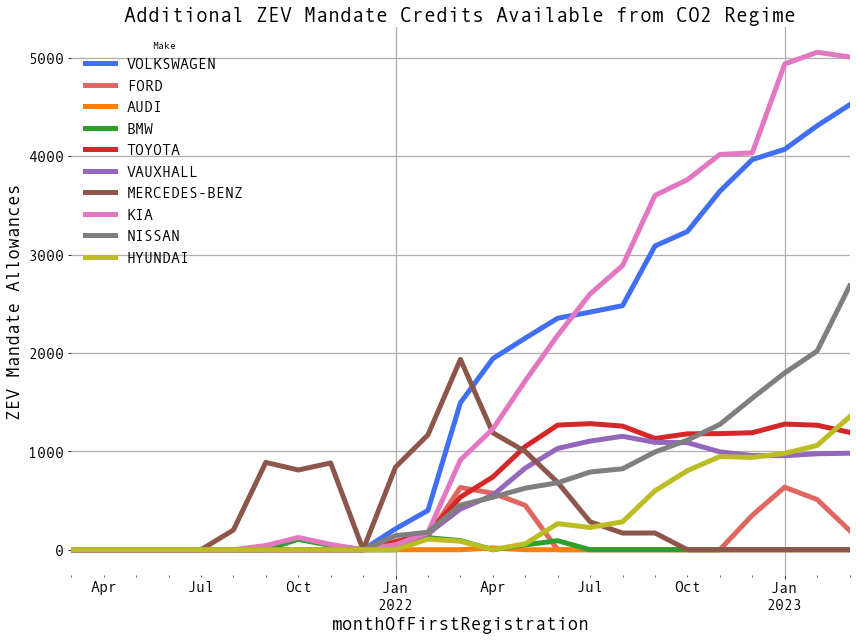

In [27]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='co2_to_mandate_allowances')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.legend(title='Make', loc='upper left')
ax.set_title('Additional ZEV Mandate Credits Available from CO2 Regime')

plt.show()

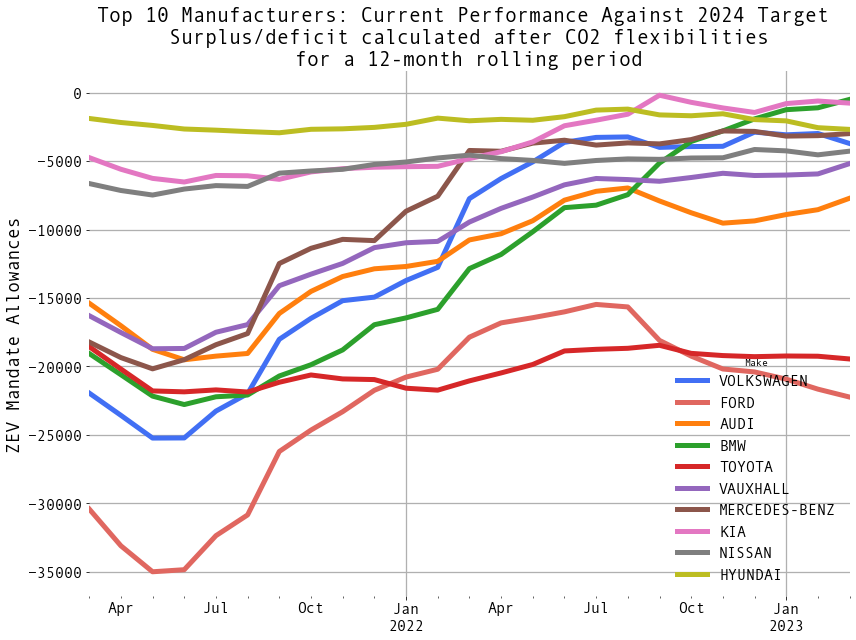

In [28]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='ZEV Surplus after CO2')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.set_xlabel('')
ax.set_title('Top 10 Manufacturers: Current Performance Against 2024 Target \n Surplus/deficit calculated after CO2 flexibilities \nfor a 12-month rolling period')
ax.legend(title='Make', loc='lower right')

plt.savefig('plots/top_10_manufacturers_zevm.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [29]:
dfa

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2_to_mandate_allowances,proposed_co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2,ZEV Surplus after CO2 - Proposed,CO2 Performance
0,JEEP,2581,2581,0,265383.0,163.136461,4.210552e+05,155672.206001,141.955000,141.955000,2013.18,-567.82,-425.865000,-425.865000,102.821775
1,DS,3464,2857,607,315869.0,123.471191,3.527572e+05,36888.192061,190.520000,190.520000,2701.92,-155.08,35.440000,35.440000,110.559678
2,LEXUS,8191,7784,407,942981.0,150.769783,1.173592e+06,230610.989825,450.505000,450.505000,6388.98,-1395.02,-944.515000,-944.515000,121.143499
3,POLESTAR,9224,2,9222,26.0,192.000000,3.840000e+02,358.000000,2.143713,1.864583,7194.72,7192.72,7194.863713,7194.584583,13.000000
4,JAGUAR,10120,6147,3973,996353.0,174.368494,1.071843e+06,75490.131766,452.036717,432.934472,7893.60,1746.60,2198.636717,2179.534472,162.087685
5,PORSCHE,13961,10106,3855,2199395.0,219.315459,2.216402e+06,17007.030018,101.838503,77.545970,10889.58,783.58,885.418503,861.125970,217.632594
6,CUPRA,16216,10917,5299,1681421.0,118.189238,1.290272e+06,-391149.088293,0.000000,0.000000,12648.48,1731.48,1731.480000,1731.480000,154.018595
7,SUZUKI,16984,16984,0,1998766.0,117.627482,1.997785e+06,-980.852363,0.000000,0.000000,13247.52,-3736.48,-3736.480000,-3736.480000,117.685233
8,FIAT,21838,16242,5596,2031878.0,130.535102,2.120151e+06,88273.121322,528.581565,676.240492,17033.64,791.64,1320.221565,1467.880492,125.100234
9,HONDA,21839,21498,341,2626905.0,124.830076,2.683597e+06,56691.979291,339.472930,454.153206,17034.42,-4463.58,-4124.107070,-4009.426794,122.192995


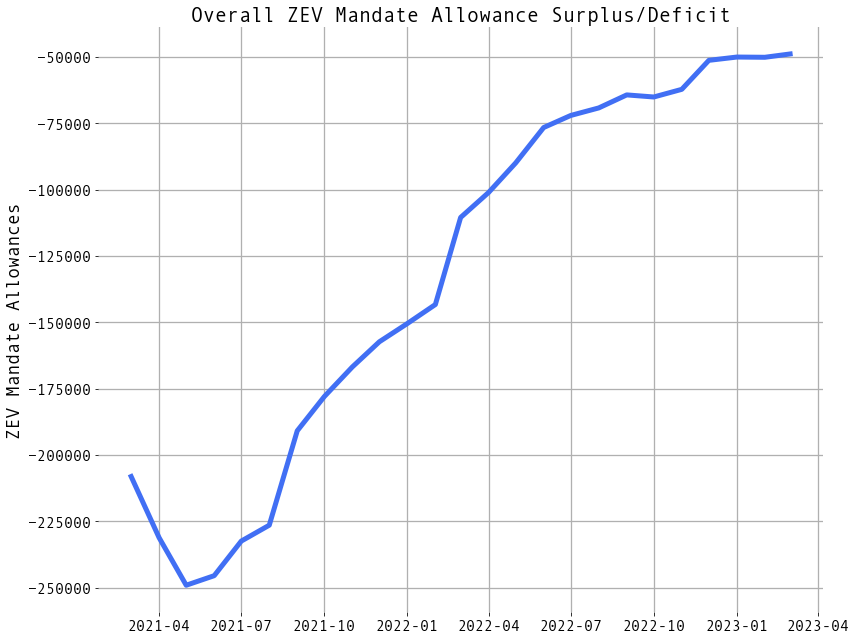

In [36]:
fig, ax = plt.subplots()

# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus'], label='Market-wide credit surplus')
ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2'], label='Market-wide credit surplus after CO2 flexibilities')
# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2 - Proposed'], label='Proposed Market-wide credit surplus after CO2 flexibilities')
ax.set_ylabel('ZEV Mandate Allowances')

# ax.legend(loc='lower right')
ax.set_title('Overall ZEV Mandate Allowance Surplus/Deficit')

plt.savefig('plots/aggregate_demand_credits.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [32]:
df['meanCo2'] = df.apply(lambda row: row.co2Activity / row.nonzevSales if row.nonzevSales >0 else np.nan , axis=1)

In [33]:
car_targets[car_targets.make.isin(top_makes)]

,make,co2Target
1,VAUXHALL,127.637466
2,HYUNDAI,127.236009
9,VOLKSWAGEN,139.808545
20,TOYOTA,110.472333
21,KIA,135.697216
31,MERCEDES-BENZ,137.088384
45,FORD,127.003107
47,NISSAN,142.632100
48,BMW,130.064052
51,AUDI,141.995362


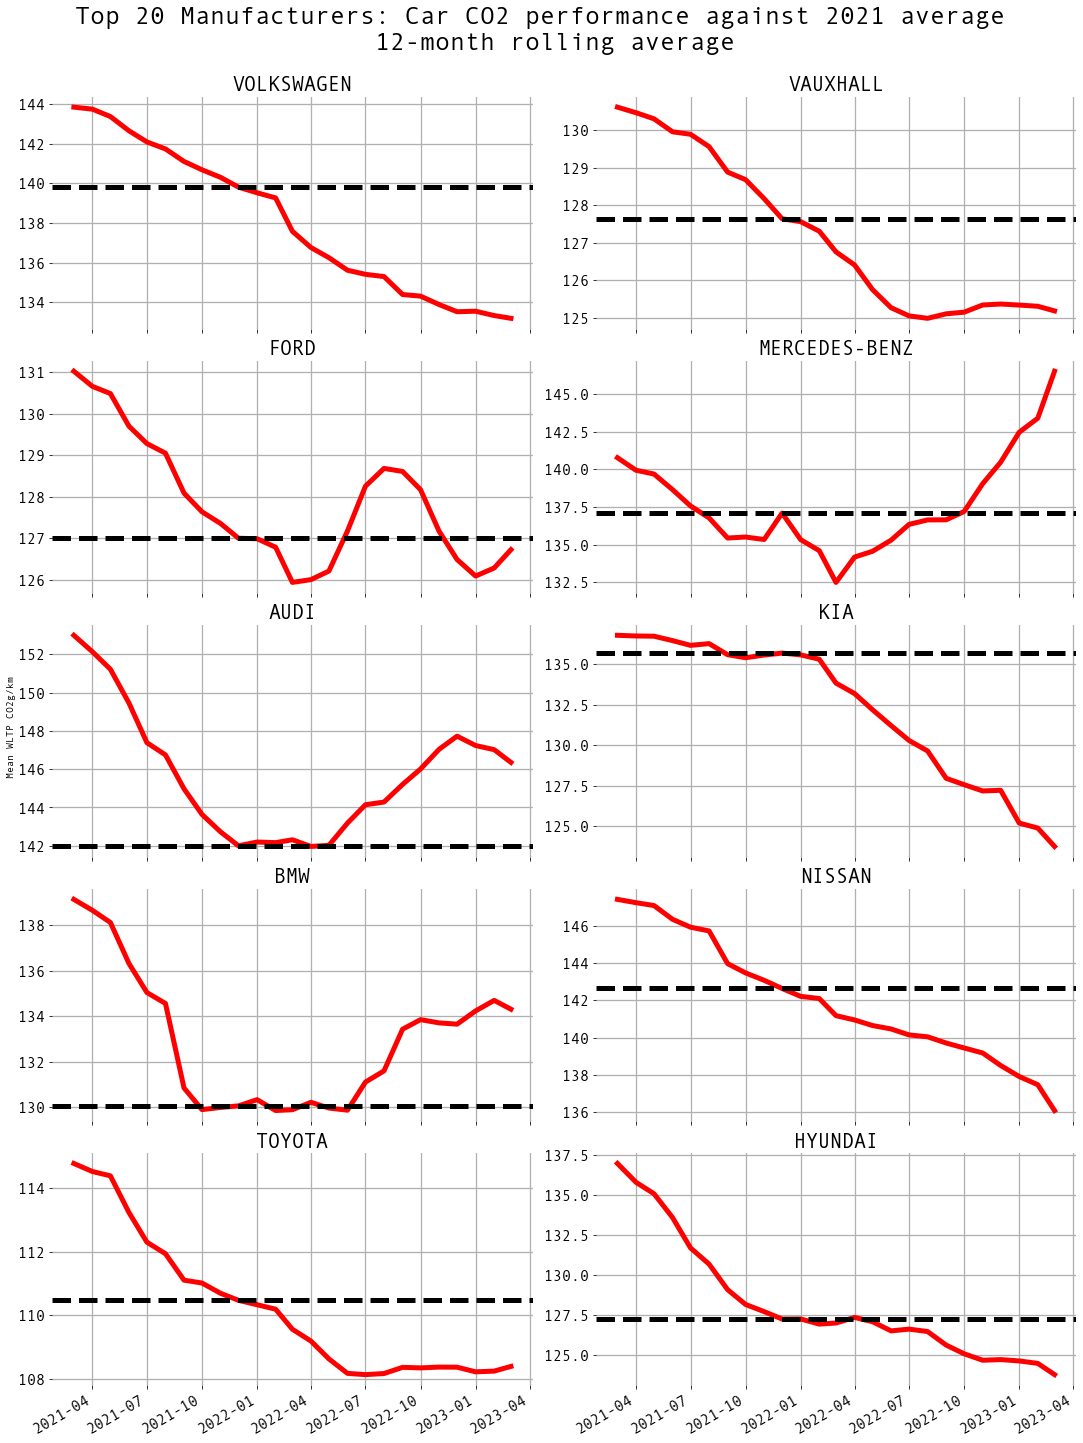

In [34]:
fig, ax = plt.subplots(5, 2, figsize=(15, 20))

# # df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes].plot(ax=ax)
# # ax.axhline(car_targets[car_targets.make.isin(top_makes)])
# # ax.set_xlabel('')
# # ax.legend(title='Make', loc='lower right')

plt_df = df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes]



for e, make in enumerate(top_makes[:5]):
    ax[e, 0].plot(plt_df[make], c='red')
    ax[e, 0].axhline(car_targets[car_targets.make == make].co2Target.values, c='black', linestyle='--')
    ax[e, 0].set_title(make)
    ax[e, 0].figure.autofmt_xdate()
    # ax[e, 0].set_ylabel('Mean WLPT CO2g/km')
    
for e, make in enumerate(top_makes[5:]):
    ax[e, 1].plot(plt_df[make], c='red')
    ax[e, 1].axhline(car_targets[car_targets.make == make].co2Target.values, c='black', label='2021 Baseline Target', linestyle='--')
    ax[e, 1].set_title(make)
    ax[e, 1].figure.autofmt_xdate()
    # ax[e, 1].set_ylabel('Mean WLPT CO2g/km')
    

fig.text(0.0, 0.5, 'Mean WLTP CO2g/km', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Top 20 Manufacturers: Car CO2 performance against 2021 average \n 12-month rolling average', y=1, fontsize=25)
fig.tight_layout()
# plt.show()

plt.savefig('plots/co2.png', transparent=False, bbox_inches='tight', dpi=300)

# ax[0, 0]